#Подключаем библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Загрузка датасета из CSV-файла

Можно найти здесь

https://drive.google.com/file/d/1coG3Daxocpe2G6-2Mvsz1v3oRzo_B8cq/view?usp=sharing


In [ ]:
# Загрузка датасета из CSV-файла
!gdown 1coG3Daxocpe2G6-2Mvsz1v3oRzo_B8cq
data = pd.read_csv('moscow_1975_2023_ok.csv')

In [ ]:
data

,date,temperature
0,1975-01-01,-5.00
1,1975-01-02,-6.10
2,1975-01-03,-3.00
3,1975-01-04,0.80
4,1975-01-05,-1.00
...,...,...
17841,2023-11-06,7.79
17842,2023-11-07,6.97
17843,2023-11-08,5.51
17844,2023-11-09,3.62


#Преобразования датафрейма для скармливания модели

In [ ]:
# Преобразование столбца с датой в объект datetime и установка его в качестве индекса
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [ ]:
data

,temperature
date,
1975-01-01,-5.00
1975-01-02,-6.10
1975-01-03,-3.00
1975-01-04,0.80
1975-01-05,-1.00
...,...
2023-11-06,7.79
2023-11-07,6.97
2023-11-08,5.51


In [ ]:
# Получение нужных столбцов для прогнозирования ('Temperature (C)')
target_column = 'temperature'
target_data = data[target_column].values.reshape(-1, 1)

In [ ]:
target_data

array([[-5.  ],
       [-6.1 ],
       [-3.  ],
       ...,
       [ 5.51],
       [ 3.62],
       [ 3.58]])

#Деление на трейн и тест с выбором даты

In [ ]:
# Определение пороговой даты для разделения выборки
threshold_date = pd.to_datetime('2023-09-01')

# Разделение данных на обучающую и тестовую выборки
train_data = data[data.index < threshold_date]['temperature']
test_data = data[data.index >= threshold_date]['temperature']

# Нормализация данных в диапазоне от 0 до 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data = scaler.transform(test_data.values.reshape(-1, 1))

In [ ]:
threshold_date

Timestamp('2023-09-01 00:00:00')

#создание последовательных выборок для обучения и тестирования

In [ ]:
# Функция для создания последовательной выборки
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [ ]:
# Задание длины последовательности и создание последовательных выборок для обучения и тестирования
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

Некоторые вычисления, которые  потом будут нужны для построения графиков

In [ ]:
print(train_data.shape)

(17775, 1)


In [ ]:
train_size=17785 #17775+10 (seq_length = 10 увеличиваем дату начала прогноза на длину окна )
# Здесь data - ваш датасет с колонками "дата" и "температура"
# предположим, что у вас есть Series с датами под названием "дата"
# и target_data - numpy массив с температурой
# определяем длину исходного датасета
data_length = len(data)

# Используем длину исходного датасета и размер обучающей выборки для определения точки, с которой начинается тестовая выборка
test_start_date = data.index[train_size]

print(test_start_date)

2023-09-11 00:00:00


# Создание и обучение модели LSTM

In [ ]:
# Создание модели LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(seq_length, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer=Adam(), loss='mse')

In [ ]:
# Обучение модели LSTM
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
278/278 [==============================] - 8s 19ms/step - loss: 0.0113 - val_loss: 0.0033
Epoch 2/20
278/278 [==============================] - 4s 16ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/20
278/278 [==============================] - 3s 11ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 4/20
278/278 [==============================] - 4s 14ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 5/20
278/278 [==============================] - 4s 14ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/20
278/278 [==============================] - 3s 12ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 7/20
278/278 [==============================] - 3s 12ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 8/20
278/278 [==============================] - 3s 12ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 9/20
278/278 [==============================] - 5s 17ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/20
278/278 [==============================] - 3s 12ms/step - loss: 0.0017 - val_lo

# Получение прогноза для тестовой выборки

In [ ]:
# Получение прогноза для тестовой выборки
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

2/2 [==============================] - 0s 10ms/step


# Вычисление метрик качества прогноза

In [ ]:
# Вычисление метрик качества прогноза
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print('LSTM')
print('Mean Squared Error:', mse_lstm)
print('Mean Absolute Error:', mae_lstm)

LSTM
Mean Squared Error: 73.80616117113154
Mean Absolute Error: 7.17068629390811


# Прогнозирование на 2 месяца вперед

In [ ]:
# Прогнозирование на 2 месяца вперед
forecast_period = 1
test_data = np.copy(y_test)  # Начнем с тестовых данных
seq_length=60
for _ in range(forecast_period):
    initial_sequence = test_data[-seq_length:].reshape(-1, 1)

    next_prediction = model_lstm.predict(initial_sequence)

    test_data = np.append(test_data, next_prediction)

# Преобразование обратно к оригинальному масштабу
predicted_temperatures = scaler.inverse_transform(test_data.reshape(-1, 1))

2/2 [==============================] - 1s 9ms/step


In [ ]:
predicted_temperatures

array([[ 13.76      ],
       [ 11.75      ],
       [ 12.65      ],
       [ 11.34      ],
       [ 12.62      ],
       [ 10.96      ],
       [ 10.81      ],
       [ 10.47      ],
       [ 11.48      ],
       [ 16.07      ],
       [ 15.61      ],
       [ 16.68      ],
       [ 14.6       ],
       [ 17.98      ],
       [ 13.88      ],
       [  9.68      ],
       [ 13.67      ],
       [ 14.5       ],
       [ 16.        ],
       [ 16.25      ],
       [ 13.86      ],
       [  9.63      ],
       [ 10.5       ],
       [ 13.25      ],
       [  7.93      ],
       [  8.25      ],
       [  3.63      ],
       [  4.38      ],
       [  2.        ],
       [  1.88      ],
       [  1.38      ],
       [  6.29      ],
       [  9.25      ],
       [  8.38      ],
       [ 11.63      ],
       [  7.25      ],
       [  1.34      ],
       [  2.09      ],
       [  3.1       ],
       [  3.01      ],
       [  1.37      ],
       [ -1.19      ],
       [  1.88      ],
       [  0

# Вывод результатов прогноза

In [ ]:
# Вывод результатов прогноза
predicted_dates = pd.date_range(start=test_start_date, periods=len(predicted_temperatures), freq='D')
predicted_data = pd.DataFrame({'Date': predicted_dates, 'Predicted_Temperature': predicted_temperatures.flatten()})

In [ ]:
predicted_data

,Date,Predicted_Temperature
0,2023-09-11,13.760000
1,2023-09-12,11.750000
2,2023-09-13,12.650000
3,2023-09-14,11.340000
4,2023-09-15,12.620000
...,...,...
116,2024-01-05,-13.090943
117,2024-01-06,-13.481665
118,2024-01-07,-14.174604
119,2024-01-08,-15.066326


#Получаем даты соответствующие температурам в тестовой выборке

In [ ]:
predicted_data.set_index('Date', inplace=True)

In [ ]:
start_date = '2023-09-01'
end_date = '2023-11-10'
test_dates = pd.date_range(start=start_date, end=end_date)

In [ ]:
test_dates

DatetimeIndex(['2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04',
               '2023-09-05', '2023-09-06', '2023-09-07', '2023-09-08',
               '2023-09-09', '2023-09-10', '2023-09-11', '2023-09-12',
               '2023-09-13', '2023-09-14', '2023-09-15', '2023-09-16',
               '2023-09-17', '2023-09-18', '2023-09-19', '2023-09-20',
               '2023-09-21', '2023-09-22', '2023-09-23', '2023-09-24',
               '2023-09-25', '2023-09-26', '2023-09-27', '2023-09-28',
               '2023-09-29', '2023-09-30', '2023-10-01', '2023-10-02',
               '2023-10-03', '2023-10-04', '2023-10-05', '2023-10-06',
               '2023-10-07', '2023-10-08', '2023-10-09', '2023-10-10',
               '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14',
               '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18',
               '2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22',
               '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26',
      

In [ ]:
# Фильтруем данные для дат, начиная с 1 января 2023 года
filtered_data = data.loc['2023-09-01':]

In [ ]:
filtered_data

,temperature
date,
2023-09-01,18.61
2023-09-02,15.37
2023-09-03,15.16
2023-09-04,15.87
2023-09-05,14.06
...,...
2023-11-06,7.79
2023-11-07,6.97
2023-11-08,5.51


In [ ]:
predicted_data

,Date,Predicted_Temperature
0,2023-09-11,13.760000
1,2023-09-12,11.750000
2,2023-09-13,12.650000
3,2023-09-14,11.340000
4,2023-09-15,12.620000
...,...,...
116,2024-01-05,-13.015141
117,2024-01-06,-13.417652
118,2024-01-07,-14.131917
119,2024-01-08,-15.051822


# Сохранение результатов прогноза в CSV-файл

In [ ]:
# Сохранение изменений обратно в CSV-файл
predicted_data.to_csv('lstm_predict.csv', index=False)

#Строим график реальных и прогнозных значений температуры

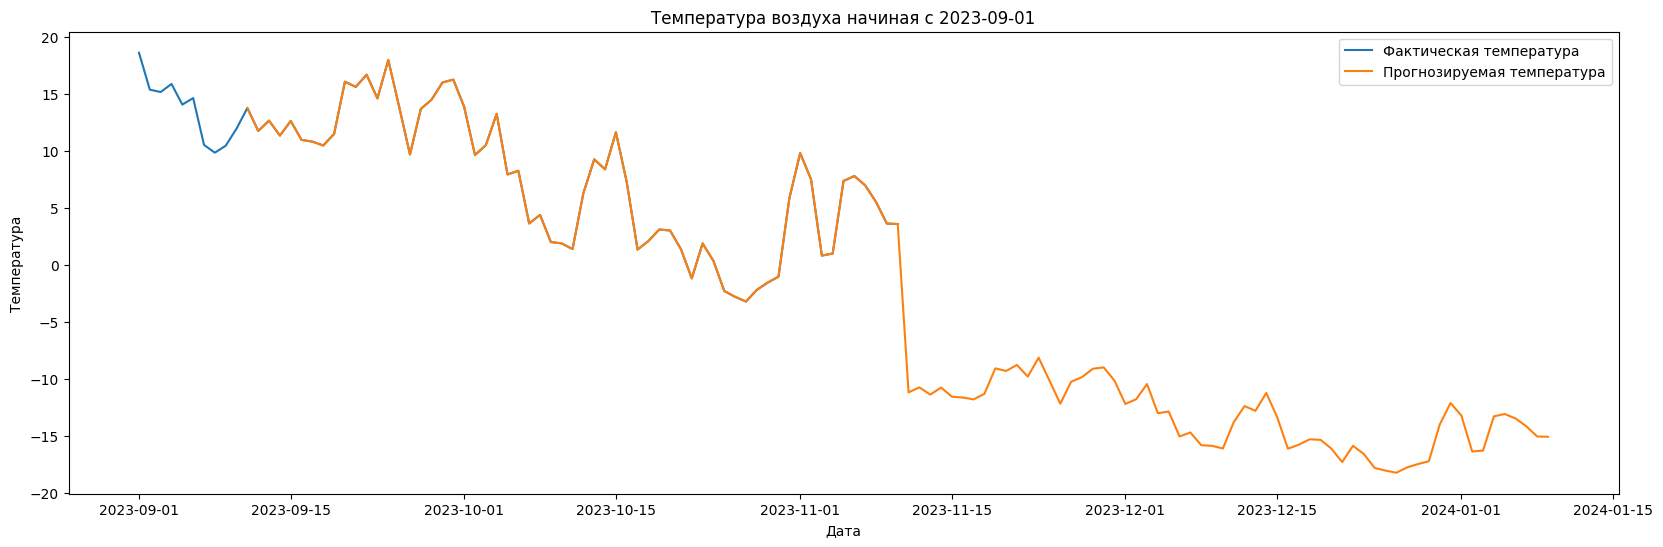

In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(filtered_data.index, filtered_data['temperature'])

plt.plot(predicted_data['Date'], predicted_data['Predicted_Temperature'])
plt.title('Температура воздуха начиная с 2023-09-01')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend(['Фактическая температура', 'Прогнозируемая температура'])
plt.show()

# Визуализация графика потерь в процессе обучения

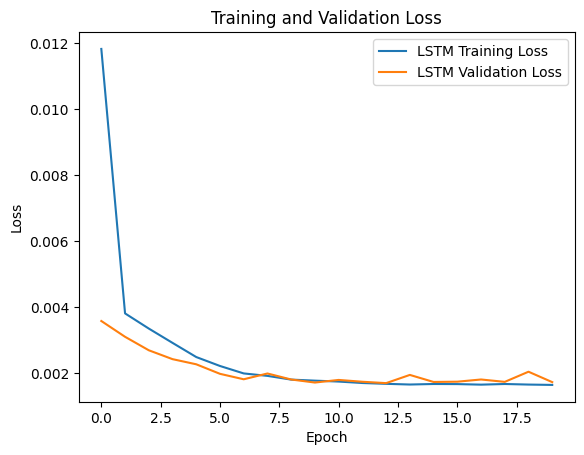

In [ ]:
# Визуализация графика потерь в процессе обучения
plt.plot(history_lstm.history['loss'], label='LSTM Training Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()